In [1]:
import numpy
import numpy as np
import pandas
import pandas as pd
from numba import njit
import sys,glob
import zipfile, os, time
import urllib3
from datetime import datetime, timedelta
import glob
import h5py
sys.path.append(os.getcwd()+'/../cds-backend/code/')
sys.path.append(os.getcwd()+'/../harvest/code/')
sys.path.append(os.getcwd()+'/../resort/rasotools-master/')
import rasotools
from harvest_convert_to_netCDF_newfixes import write_dict_h5
import cds_eua3 as eua
eua.logging_set_level(30)
import xarray as xr

import cdsapi, zipfile, os, time
#import schedule
import copy
from shutil import copyfile
import multiprocessing
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab


In [2]:
@njit        
def tcost(dists, slopes, cost):
    # calculate trend heterogeneity cost function

    id = 0
    goodstats = 0
    tcost = 0.
    for l in range(slopes.shape[0]):
        cost[l] = 0.
    for l in range(slopes.shape[0]):
        if slopes[l] == slopes[l]:
            goodstats += 1
            for k in range(l, slopes.shape[0]):
                if slopes[l] == slopes[l] and slopes[k] == slopes[k]:
                    s = (slopes[l]-slopes[k])*dists[id]
                    cost[l] += s*s
                    cost[k] += s*s
                    if l == 24 and k == 29:
                        print((dists[id], slopes[l], slopes[k]))
                id += 1
            if goodstats > 0:
                tcost += cost[l]
        else:
            id += slopes.shape[0]-l

    if goodstats > 0:
        tcost /= goodstats
        for l in range(slopes.shape[0]):
            cost[l] /= goodstats

    return tcost

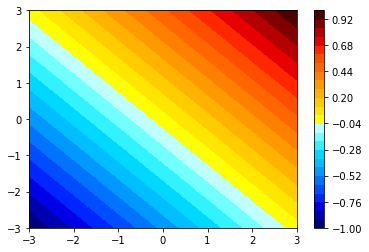

ready


In [3]:
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import numpy

def rgb(r,g,b):
    return tuple(numpy.asarray([r,g,b],dtype=numpy.float))

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    se = [(None,) * 3, 0.0]
    for s in seq:
        se.append(s[0])
        se.append(s[1])#+ list(seq) +
        seq=se+[ (None,) * 3]
        cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

rgblist=["rgb(0,0,0.3)", "rgb(0,0,0.5)",
"rgb(0,0,0.7)", "rgb(0,0,0.9)", "rgb(0,0.15,1)",
"rgb(0,0.3,1)", "rgb(0,0.45,1)", "rgb(0,0.6,1)",
"rgb(0,0.75,1)", "rgb(0,0.85,1)", "rgb(0.2,0.95,1)",
"rgb(0.45,1,1)", "rgb(0.75,1,1)", "rgb(1,1,0)",
"rgb(1,0.9,0)", "rgb(1,0.8,0)", "rgb(1,0.7,0)",
"rgb(1,0.6,0)", "rgb(1,0.5,0)", "rgb(1,0.4,0)",
"rgb(1,0.3,0)", "rgb(1,0.15,0)", "rgb(0.9,0,0)",
"rgb(0.7,0,0)", "rgb(0.5,0,0)", "rgb(0.3,0,0)"]
rgblist2=zip([eval(rgblist[l]) for l in range(len(rgblist))],numpy.linspace(0,1,len(rgblist)))

cmnew=make_colormap(rgblist2)

x,y=numpy.meshgrid(numpy.linspace(-3,3,101),numpy.linspace(-3,3,101))
gauss=x/6+y/6
clist=numpy.linspace(-1,1,26)
plt.contourf(x,y,gauss,clist,cmap=cmnew)
plt.colorbar()
plt.show()
print('ready')

# Trends

---

## Requesting CUAN Data

In [27]:
t0 = time.time()

c = cdsapi.Client()
r = c.retrieve(
    'insitu-comprehensive-upper-air-observation-network',
    {
        'variable':['air_temperature',],
        'statid':'10393',
        'date': '19780101-20181231',
        'optional':'bias_estimate',
        'pressure_level': '100',
        'format': 'csv',
    })
if True:
    # Start Download
    r.download(target='download.zip')
    # Check file size
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    
print("Time elapsed: ", time.time()-t0, "s")
z = zipfile.ZipFile('download.zip')
print("Unzipping retrieved files")
z.extractall(path='./comp100hpa_be')
z.close()
os.remove('download.zip')


/jetfs/spack/opt/spack/linux-rhel8-skylake_avx512/gcc-8.3.1/miniconda3-4.8.2-3m7b6t2kgedyr3jnd2nasmgiq7wm27iv/lib/python3.8/site-packages/urllib3/connectionpool.py:997: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sis-dev.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2020-11-30 09:58:47,672 INFO Welcome to the CDS
2020-11-30 09:58:47,673 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
/jetfs/spack/opt/spack/linux-rhel8-skylake_avx512/gcc-8.3.1/miniconda3-4.8.2-3m7b6t2kgedyr3jnd2nasmgiq7wm27iv/lib/python3.8/site-packages/urllib3/connectionpool.py:997: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sis-dev.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adva

Time elapsed:  8.624866485595703 s
Unzipping retrieved files


In [36]:
compf = glob.glob('./comp50hpa_be/*.csv')
print(len(compf))

1


In [37]:
a = pd.read_csv(compf[0])
a
# for i in a.

,obs_id,bias_estimate,lat,lon,plev,ta,time,trajectory_label,statid,statindex
0,0,0.000000,54.3800,18.4700,5000.0,221.90,1985-07-25 00:00:00,10000000007,0-20000-0-12150,0
1,1,0.549561,38.6500,-88.9700,5000.0,210.90,1978-01-01 00:00:00,20000006004,0-20000-0-03879,1
2,2,0.845529,38.6500,-88.9700,5000.0,210.20,1978-01-01 12:00:00,20000006005,0-20000-0-03879,1
3,3,0.549561,38.6500,-88.9700,5000.0,211.90,1978-01-02 00:00:00,20000006006,0-20000-0-03879,1
4,4,0.845529,38.6500,-88.9700,5000.0,210.50,1978-01-02 12:00:00,20000006007,0-20000-0-03879,1
...,...,...,...,...,...,...,...,...,...,...
16488889,16488889,0.000000,40.6667,-89.6833,5000.0,215.55,1995-02-12 12:00:00,30000029191,0-20000-0-72532,2048
16488890,16488890,0.000000,40.6667,-89.6833,5000.0,216.95,1995-02-13 00:00:00,30000029192,0-20000-0-72532,2048
16488891,16488891,0.000000,40.6667,-89.6833,5000.0,215.25,1995-02-13 12:00:00,30000029193,0-20000-0-72532,2048
16488892,16488892,0.000000,40.6667,-89.6833,5000.0,215.65,1995-02-14 00:00:00,30000029194,0-20000-0-72532,2048


## Creating Trendfiles from CUAN

In [81]:
tt = time.time()
stations = pickle.load( open( "stations.p", "rb" ))
out = stations[0:0]

start = 1979
end = 2018
a = a[a.time.str[:4] <= str(end)]
intervall = end - start
print(time.time()-tt)
for i in a.statid.drop_duplicates()[:10]:
    da = a[a.statid == i]
    timelen = len(da.time.str[:10].drop_duplicates())
    if timelen >= 0.9*intervall*365:
        selected = np.asarray(da.ta)np.asarray(da.bias_estimate)
        datlen = len(selected)
        try:
            coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
            trend = coefficients[0]*(10/intervall*len(da.ta))
            out.loc[len(out.index)] = [trend, da.lon.iloc[0], da.lat.iloc[0]]
        except:
            pass
pickle.dump( out, open( "/raid60/scratch/uli/CUAN_A_100hPa_1979_2018_Trend.p", "wb" ))
print(time.time()-tt)

5.6489644050598145
12.800855875015259


In [ ]:
tt = time.time()
stations = pickle.load( open( "stations.p", "rb" ))
out = stations[0:0]

start = 1979
end = 2018
a = a[a.time.str[:4] <= str(end)]
intervall = end - start
print(time.time()-tt)
for i in a.statid.drop_duplicates()[:10]:
    da = a[a.statid == i]
    timelen = len(da.time.str[:10].drop_duplicates())
    if timelen >= 0.9*intervall*365:
        selected = np.asarray(da.ta)
        datlen = len(selected)
        try:
            coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
            trend = coefficients[0]*(10/intervall*len(da.ta))
            out.loc[len(out.index)] = [trend, da.lon.iloc[0], da.lat.iloc[0]]
        except:
            pass
pickle.dump( out, open( "/raid60/scratch/uli/CUAN_100hPa_1979_2018_Trend.p", "wb" ))
print(time.time()-tt)

## Splitting IGRA Files into single station year files

In [3]:
def savetoarray(file, dataset: str='IGRA_H', dest: str='./temp100/'):
    yr = file.split('/')[5]
    plev = 10000
    chunk = pd.read_csv(file, header=12, index_col=False, usecols=['station_name', 'observed_value', 'air_pressure'])
    stations = chunk.station_name.drop_duplicates()
    for i in stations:
        if not os.path.isfile( dest + dataset + '_' + i + '_' + yr + '_' + str(plev) + ".p"):
            da = chunk[chunk.station_name == i]
            da = da[da.air_pressure == plev]
            pickle.dump( np.asarray(da.observed_value), open( dest + dataset + '_' + i + '_' + yr + '_' + str(plev) + ".p", "wb" ))

## Creating Trendfiles from IGRA and IGRA_H

In [12]:
stations = pickle.load( open( "stations.p", "rb" ))
start = 1979
end = 2006
intervall = end - start
for i in range(len(stations.station_name)):
    files = glob.glob('/raid60/scratch/uli/IGRA_Data/temp50h/IGRA_H_' + stations.station_name.iloc[i] + '*.p')
#     files = glob.glob('/raid60/scratch/uli/IGRA_Data/temp50/IGRA_' + stations.station_name.iloc[i] + '*.p')
    filesinintervall = []
    for o in files:
        yr = int(o.split('_')[-2])
        if yr <= end and yr >= start:
            filesinintervall.append(o)
    temp = []
    for j in filesinintervall:
        temp.extend(pickle.load( open( j, "rb" )))
    if len(temp) >= 0.9*intervall*365:
        selected = np.asarray(temp)[~np.isnan(np.asarray(temp))]
        datlen = len(selected)
        try:
            coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
            stations.station_name.iloc[i] = coefficients[0]*(10/intervall*len(temp))
        except:
            stations.station_name.iloc[i] = np.nan
    else:
        stations.station_name.iloc[i] = np.nan
pickle.dump( stations, open( "IGRA_H_50hPa_1979_2006_Trend.p", "wb" ))
# pickle.dump( stations, open( "IGRA_50hPa_1979_2006_Trend.p", "wb" ))

In [13]:
stations = pickle.load( open( "stations.p", "rb" ))
start = 1979
end = 2006
intervall = end - start
mindata = int(intervall*0.9)
for i in range(len(stations.station_name)):
    files = glob.glob('/raid60/scratch/uli/IGRA_Data/temp100h/IGRA_H_' + stations.station_name.iloc[i] + '*.p')
#     files = glob.glob('/raid60/scratch/uli/IGRA_Data/temp100/IGRA_' + stations.station_name.iloc[i] + '*.p')
    filesinintervall = []
    for o in files:
        yr = int(o.split('_')[-2])
        if yr <= end and yr >= start:
            filesinintervall.append(o)
    temp = []
    for j in filesinintervall:
        temp.extend(pickle.load( open( j, "rb" )))
    if len(temp) >= 0.9*intervall*365:
        selected = np.asarray(temp)[~np.isnan(np.asarray(temp))]
        datlen = len(selected)
        try:
            coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
            stations.station_name.iloc[i] = coefficients[0]*(10/intervall*len(temp))
        except:
            stations.station_name.iloc[i] = np.nan
    else:
        stations.station_name.iloc[i] = np.nan
pickle.dump( stations, open( "IGRA_H_100hPa_1979_2006_Trend.p", "wb" ))
# pickle.dump( stations, open( "IGRA_100hPa_1979_2006_Trend.p", "wb" ))

In [14]:
stations = pickle.load( open( "stations.p", "rb" ))
start = 1979
end = 2006
intervall = end - start
mindata = int(intervall*0.9)
for i in range(len(stations.station_name)):
    files = glob.glob('/raid60/scratch/uli/IGRA_Data/temp300h/IGRA_H_' + stations.station_name.iloc[i] + '*.p')
#     files = glob.glob('/raid60/scratch/uli/IGRA_Data/temp300/IGRA_' + stations.station_name.iloc[i] + '*.p')
    filesinintervall = []
    for o in files:
        yr = int(o.split('_')[-2])
        if yr <= end and yr >= start:
            filesinintervall.append(o)
    temp = []
    for j in filesinintervall:
        temp.extend(pickle.load( open( j, "rb" )))
    if len(temp) >= 0.9*intervall*365:
        selected = np.asarray(temp)[~np.isnan(np.asarray(temp))]
        datlen = len(selected)
        try:
            coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
            stations.station_name.iloc[i] = coefficients[0]*(10/intervall*len(temp))
        except:
            stations.station_name.iloc[i] = np.nan
    else:
        stations.station_name.iloc[i] = np.nan
pickle.dump( stations, open( "IGRA_H_300hPa_1979_2006_Trend.p", "wb" ))
# pickle.dump( stations, open( "IGRA_300hPa_1979_2006_Trend.p", "wb" ))

In [15]:
stations = pickle.load( open( "stations.p", "rb" ))
start = 1979
end = 2018
intervall = end - start
mindata = int(intervall*0.9)
for i in range(len(stations.station_name)):
    files = glob.glob('/raid60/scratch/uli/IGRA_Data/temp100h/IGRA_H_' + stations.station_name.iloc[i] + '*.p')
#     files = glob.glob('/raid60/scratch/uli/IGRA_Data/temp100/IGRA_' + stations.station_name.iloc[i] + '*.p')
    filesinintervall = []
    for o in files:
        yr = int(o.split('_')[-2])
        if yr <= end and yr >= start:
            filesinintervall.append(o)
    temp = []
    for j in filesinintervall:
        temp.extend(pickle.load( open( j, "rb" )))
    if len(temp) >= 0.9*intervall*365:
        selected = np.asarray(temp)[~np.isnan(np.asarray(temp))]
        datlen = len(selected)
        try:
            coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
            stations.station_name.iloc[i] = coefficients[0]*(10/intervall*len(temp))
        except:
            stations.station_name.iloc[i] = np.nan
    else:
        stations.station_name.iloc[i] = np.nan
pickle.dump( stations, open( "IGRA_H_100hPa_1979_2018_Trend.p", "wb" ))
# pickle.dump( stations, open( "IGRA_100hPa_1979_2018_Trend.p", "wb" ))

In [16]:
stations = pickle.load( open( "stations.p", "rb" ))
start = 1979
end = 2018
intervall = end - start
mindata = int(intervall*0.9)
for i in range(len(stations.station_name)):
    files = glob.glob('/raid60/scratch/uli/IGRA_Data/temp50h/IGRA_H_' + stations.station_name.iloc[i] + '*.p')
#     files = glob.glob('/raid60/scratch/uli/IGRA_Data/temp50/IGRA_' + stations.station_name.iloc[i] + '*.p')
    filesinintervall = []
    for o in files:
        yr = int(o.split('_')[-2])
        if yr <= end and yr >= start:
            filesinintervall.append(o)
    temp = []
    for j in filesinintervall:
        temp.extend(pickle.load( open( j, "rb" )))
    if len(temp) >= 0.9*intervall*365:
        selected = np.asarray(temp)[~np.isnan(np.asarray(temp))]
        datlen = len(selected)
        try:
            coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
            stations.station_name.iloc[i] = coefficients[0]*(10/intervall*len(temp))
        except:
            stations.station_name.iloc[i] = np.nan
    else:
        stations.station_name.iloc[i] = np.nan
pickle.dump( stations, open( "IGRA_H_50hPa_1979_2018_Trend.p", "wb" ))
# pickle.dump( stations, open( "IGRA_50hPa_1979_2018_Trend.p", "wb" ))

In [17]:
stations = pickle.load( open( "stations.p", "rb" ))
start = 1979
end = 2018
intervall = end - start
mindata = int(intervall*0.9)
for i in range(len(stations.station_name)):
    files = glob.glob('/raid60/scratch/uli/IGRA_Data/temp300h/IGRA_H_' + stations.station_name.iloc[i] + '*.p')
#     files = glob.glob('/raid60/scratch/uli/IGRA_Data/temp300/IGRA_' + stations.station_name.iloc[i] + '*.p')
    filesinintervall = []
    for o in files:
        yr = int(o.split('_')[-2])
        if yr <= end and yr >= start:
            filesinintervall.append(o)
    temp = []
    for j in filesinintervall:
        temp.extend(pickle.load( open( j, "rb" )))
    if len(temp) >= 0.9*intervall*365:
        selected = np.asarray(temp)[~np.isnan(np.asarray(temp))]
        datlen = len(selected)
        try:
            coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
            stations.station_name.iloc[i] = coefficients[0]*(10/intervall*len(temp))
        except:
            stations.station_name.iloc[i] = np.nan
    else:
        stations.station_name.iloc[i] = np.nan
pickle.dump( stations, open( "IGRA_H_300hPa_1979_2018_Trend.p", "wb" ))
# pickle.dump( stations, open( "IGRA_300hPa_1978_2018_Trend.p", "wb" ))

## Create Stations File

In [4]:
# stations = []
# for i in range(len(files)):
#     if i == 0:
#         chunk = pd.read_csv(files[i], header=12, index_col=False, usecols=['location_longitude', 'location_latitude', 'station_name'])
#         stations = chunk.drop_duplicates(['station_name'])
#     else:
#         chunk = pd.read_csv(files[i], header=12, index_col=False, usecols=['location_longitude', 'location_latitude', 'station_name'])
#         stations = pd.concat([stations, chunk.drop_duplicates(['station_name'])], ignore_index=True)
# stations = stations.drop_duplicates('station_name')
# pickle.dump( stations, open( "stations.p", "wb" ))

In [22]:
stations = pickle.load( open( "stations.p", "rb" ))
stations

,station_name,location_longitude,location_latitude
0,KRM00091487,-159.3670,3.8500
1,CHM00055664,87.0830,28.6330
2,CHM00056444,98.8830,28.4500
3,BMM00048062,92.8830,20.1330
4,CHM00057290,114.0500,32.9670
...,...,...,...
36592,INM00043110,73.3333,16.9833
37459,INM00042165,73.3000,28.0000
37460,INM00042328,70.9167,26.9000
37461,RPM00098233,121.7525,17.6375


## Calculating Costfunction from Trends

In [108]:
trends = glob.glob('trends/COMP*Trend.p')
trends

['trends/COMP_50hPa_1979_2018_Trend.p',
 'trends/COMP_100hPa_1979_2018_Trend.p',
 'trends/COMP_A_100hPa_1979_2018_Trend.p',
 'trends/COMP_A_50hPa_1979_2018_Trend.p']

In [109]:
test = pickle.load( open( trends[0], "rb" ))
a = rasotools.plot._helpers.cost(test.location_longitude, test.location_latitude, test.station_name)
np.sum(a)/len(a)

59.44775920952208

/jetfs/home/uvoggenberger/.local/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/jetfs/home/uvoggenberger/.local/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


<GeoAxesSubplot:title={'center':' (# 297 / 297)'}>

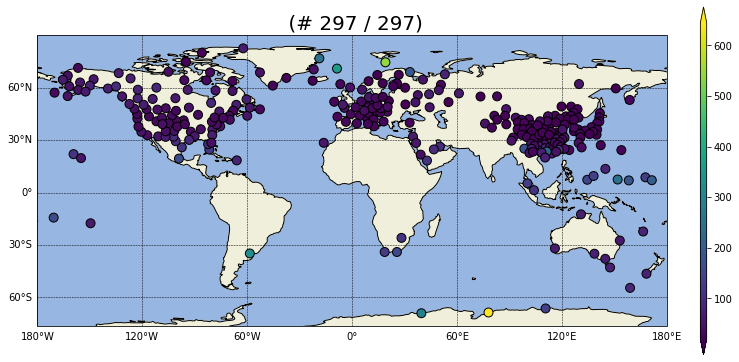

In [110]:
rasotools.plot.map.costfunction(test.location_longitude, test.location_latitude, test.station_name)

## Plotting Trends

In [31]:
def plt_trends(i):
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (12, 8),
             'axes.labelsize': 'x-large',
             'axes.titlesize': 20,
             'xtick.labelsize':'medium',
             'ytick.labelsize':'medium'}
    pylab.rcParams.update(params)

    igra = pickle.load( open( i, "rb" ))
    i = i.split('/')[-1]
    da = igra.dropna()
    statnum = len(da)
    a = rasotools.plot._helpers.cost(np.asarray(da.location_longitude), np.asarray(da.location_latitude), np.asarray(da.station_name))
    cost = np.sum(a)/len(a)
    
    ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.coastlines()

    reduced = np.asarray(da['station_name'])
    longitudes = list(da['location_longitude'])
    latitudes = list(da['location_latitude'])
    plt.scatter(longitudes, latitudes, s=40, alpha=1,
                c= da['station_name'],
                cmap=cmnew,
                vmin=-2,
                vmax=2)
    plt.colorbar(orientation='horizontal', label='K/10a', shrink=0.9, pad=0.05)
    plt.tight_layout()
#     plt.title('CUAN'+i.split('.')[0][4:]+'\n'+'trend heterogeneity cost function: '+'{:.2f}'.format(cost)+'\n'+'number of stations: '+str(statnum))
#     plt.savefig('plots/'+'CUAN'+i[4:]+'ng', bbox_inches='tight')
    plt.title(i.split('.')[0]+'\n'+'trend heterogeneity cost function: '+'{:.2f}'.format(cost)+'\n'+'number of stations: '+str(statnum))
    plt.savefig('plots/'+i+'ng', bbox_inches='tight')
    plt.close()


In [32]:
trends = glob.glob('trends/IGRA*Trend.p')
trends

['trends/IGRA_300hPa_1978_2018_Trend.p',
 'trends/IGRA_100hPa_1979_2018_Trend.p',
 'trends/IGRA_50hPa_1979_2006_Trend.p',
 'trends/IGRA_300hPa_1979_2006_Trend.p',
 'trends/IGRA_H_100hPa_1979_2018_Trend.p',
 'trends/IGRA_H_300hPa_1979_2018_Trend.p',
 'trends/IGRA_50hPa_1979_2018_Trend.p',
 'trends/IGRA_H_50hPa_1979_2018_Trend.p',
 'trends/IGRA_100hPa_1979_2006_Trend.p',
 'trends/IGRA_H_300hPa_1979_2006_Trend.p',
 'trends/IGRA_H_100hPa_1979_2006_Trend.p',
 'trends/IGRA_H_50hPa_1979_2006_Trend.p']

In [33]:
for i in trends:
    plt_trends(i)

<ipython-input-31-5fe2d2aff2c0>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-31-5fe2d2aff2c0>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-31-5fe2d2aff2c0>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-31-5fe2d2aff2c0>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-31-5fe2d2aff2c0>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-31-5fe2d2aff2c0>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
 

---

---

In [115]:
trends = glob.glob('trends/IGRA*Trend.p')
trends

['trends/IGRA_300hPa_1978_2018_Trend.p',
 'trends/IGRA_100hPa_1979_2018_Trend.p',
 'trends/IGRA_50hPa_1979_2006_Trend.p',
 'trends/IGRA_300hPa_1979_2006_Trend.p',
 'trends/IGRA_H_100hPa_1979_2018_Trend.p',
 'trends/IGRA_H_300hPa_1979_2018_Trend.p',
 'trends/IGRA_50hPa_1979_2018_Trend.p',
 'trends/IGRA_H_50hPa_1979_2018_Trend.p',
 'trends/IGRA_100hPa_1979_2006_Trend.p',
 'trends/IGRA_H_300hPa_1979_2006_Trend.p',
 'trends/IGRA_H_100hPa_1979_2006_Trend.p',
 'trends/IGRA_H_50hPa_1979_2006_Trend.p']

In [117]:
igra = pickle.load( open( trends[1], "rb" ))
igra.dropna()

,station_name,location_longitude,location_latitude
1,-2.85205e-14,87.0830,28.6330
6,-20.6227,99.0670,29.9670
7,17.2326,100.2330,26.8670
8,-0.509461,72.6670,32.0500
11,0.469389,99.8000,33.8000
...,...,...,...
4839,-0.0920292,58.2830,23.5830
5625,-0.123394,47.9714,29.2425
5724,1.57894,81.1500,16.2000
5744,0.0313201,77.3500,23.2833


In [118]:
igra = pickle.load( open( trends[4], "rb" ))
igra.dropna()

,station_name,location_longitude,location_latitude
59,-0.0743995,67.1333,24.9000
67,-0.207428,97.1667,31.1500
89,-0.148607,98.5056,24.9844
91,-0.0147298,46.2833,38.0833
99,-0.0498128,107.3667,40.7333
...,...,...,...
4839,0.00798786,58.2830,23.5830
5625,-7.55609e-05,47.9714,29.2425
6662,-0.0369759,46.7167,24.9333
6665,-0.0804505,54.6500,24.4333


In [119]:
trends = glob.glob('trends/COMP*Trend.p')
trends

['trends/COMP_50hPa_1979_2018_Trend.p',
 'trends/COMP_100hPa_1979_2018_Trend.p',
 'trends/COMP_A_100hPa_1979_2018_Trend.p',
 'trends/COMP_A_50hPa_1979_2018_Trend.p',
 'trends/COMP_300hPa_1979_2018_Trend.p',
 'trends/COMP_A_300hPa_1979_2018_Trend.p']

In [122]:
igra = pickle.load( open( trends[1], "rb" ))
igra.dropna()

,station_name,location_longitude,location_latitude
0,-1.241995,26.13000,44.5000
1,-0.941611,-8.67000,70.9300
2,-0.145014,73.40000,54.9300
3,-0.279056,40.51140,64.6247
4,-0.239013,-0.70000,44.8300
...,...,...,...
372,-0.474302,-108.52500,39.1200
373,-0.394466,-122.22000,37.7500
374,-0.357613,-73.80001,42.7500
375,-0.334863,-80.23001,40.5300


In [123]:
igra = pickle.load( open( trends[2], "rb" ))
igra.dropna()

,station_name,location_longitude,location_latitude
0,-0.436155,26.13000,44.5000
1,-0.892139,-8.67000,70.9300
2,-0.272594,73.40000,54.9300
3,-0.281779,40.51140,64.6247
4,-0.245142,-0.70000,44.8300
...,...,...,...
372,-0.283173,-108.52500,39.1200
373,-0.190933,-122.22000,37.7500
374,-0.300131,-73.80001,42.7500
375,-0.258168,-80.23001,40.5300
